In [1]:
import json
import numpy as np
import xml.etree.ElementTree as ET
import os

from __future__ import division

In [3]:
data_path = '/media/yifeng/Yifeng_Seagate/DataSets/gree_dataset/Annotations'
fname = sorted(os.listdir(data_path))

In [4]:
bboxes = []
for name in fname:
    name = os.path.join(data_path, name)
    tree = ET.parse(name)
    root = tree.getroot()
    for bbox in root.findall('object'):
        box = bbox.find('bndbox')
        box = [box.find('xmin'), box.find('ymin'), box.find('xmax'), box.find('ymax')]
        box = [ int(i.text) for i in box ]
        area = (box[2] - box[0]) * (box[3] - box[1])
        if area <= 0:
            print "BOX WITH 0 AREA! : {} So deprecated".format(name)
        else:
            bboxes.append(box)
bboxes = np.asarray(bboxes)
print bboxes.shape

BOX WITH 0 AREA! : /media/yifeng/Yifeng_Seagate/DataSets/gree_dataset/Annotations/112.xml So deprecated
(4711, 4)


## change bboxes into center style

In [5]:
width = bboxes[:, 2] - bboxes[:, 0]
height = bboxes[: ,3] - bboxes[:, 1]
bboxes = np.asarray([-width/2, -height/2, width/2 , height/2]).T
print bboxes.shape

(4711, 4)


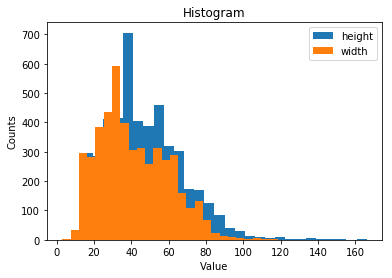

In [30]:
import matplotlib.pyplot as plt

plt.hist(height, bins=30, label='height')
plt.hist(width, bins=30, label='width')
plt.title("Histogram")
# plt.xlabel("Value")
# plt.ylabel("Counts")

# fig = plt.gcf()
# plt.show()

# plt.hist(width, bins=30)
# plt.title("Width Histogram")
plt.xlabel("Value")
plt.ylabel("Counts")
plt.legend()

fig = plt.gcf()
plt.show()

In [7]:
def jaccard_distance(bboxes, means):
    """takes [N, 4] bboxes, [K, 4] means returns [K, N] jaccard distance.
    """
    N = bboxes.shape[0]
    K = means.shape[0]
#         
    assert np.any(bboxes[:, 2] >= bboxes[:, 0])
    assert np.any(bboxes[:, 3] >= bboxes[:, 1])
    assert np.any(means[:, 2] >= means[:, 0])
    assert np.any(means[:, 3] >= means[:, 1])
    
    xmin, ymin, xmax, ymax = np.split(bboxes, 4, axis=1)
    means_area = (means[:,2] - means[:, 0]) * (means[:,3] - means[:, 1]) 
    bboxes_area = (xmax - xmin) * (ymax - ymin)
    assert np.all(bboxes_area != 0)
    jaccards = np.zeros([K, N], dtype=np.float32)
    
    for idx, box in enumerate(means):
        i_minx = np.maximum(xmin, box[0])
        i_maxx = np.minimum(xmax, box[2])
        i_miny = np.maximum(ymin, box[1])
        i_maxy = np.minimum(ymax, box[3])

        b_area = (box[2] - box[0]) * (box[3] - box[1])
        assert b_area == means_area[idx], '{}, {}\n'.format(b_area, means_area[idx])
        
        i_area = np.maximum((i_maxx - i_minx),0) * np.maximum((i_maxy - i_miny),0)
        u_area = bboxes_area + b_area - i_area
        assert (np.all(u_area != 0)), "{}".format(np.where(u_area==0))
        u_area = (u_area > 0) * (1.0 / u_area) + (u_area == 0) * 0
        iou = i_area * u_area
        jaccards[idx, :] = iou.flatten()
    return jaccards

def k_means(bboxes, K, init=None, dis_func = jaccard_distance, cvg_th=1e-3, max_iter=1e3, verbose=False):
    # initialization
    N = bboxes.shape[0]
    assert N >= np.unique(bboxes, axis=0).shape[0], 'Too Much Clusters! Try reduce K to less than {}！'\
                                                        .format(np.unique(bboxes, axis=0).shape[0])    
    if init is None:
        minw, maxw, minh, maxh = np.min(bboxes[:,2]), np.max(bboxes[:,2]), np.min(bboxes[:,3]), np.max(bboxes[:,3]) 
        epsilon = 1e-2
        randw = np.random.uniform(minw-epsilon, maxw+epsilon, size=[K])
        randh = np.random.uniform(minh-epsilon, maxh+epsilon, size=[K])
        means = np.asarray([-randw, -randh, randw, randh]).T
        if verbose:
            print("Input BBOXS HAVE W : [{} to {}] H:[{} to {}]".format(minw, maxw, minh, maxh))
    else:
        assert init.shape == (K, 4)
        means = init
        
    if cvg_th is None:
        cvg_th = 0
    
    for it in range(int(max_iter)):
        # assign
        distance = dis_func(bboxes, means)
        belongs = np.argmax(distance, axis=0)

        # update
        new = np.zeros([K, 4], dtype=np.float32)
        cnt = np.zeros([K, 1])
        for i in range(N):
            new[belongs[i],:] += bboxes[i, :]
            cnt[belongs[i]] += 1
        for i in range(K):
            if cnt[i] == 0:
                # set to a new random mean
                randw = np.random.uniform(minw-epsilon, maxw+epsilon, size=1)
                randh = np.random.uniform(minh-epsilon, maxh+epsilon, size=1)
                means = np.asarray([-randw, -randh, randw, randh]).flatten()
                new[i, :] = means
            else:
                new[i, :] /= cnt[i]
        metric = np.max(np.abs(new - means))
        if it % 10 == 0 and verbose:
            print("Iter : {} with {:.3f} still changing"\
                  .format(it, metric))
        if metric < cvg_th:
            break
        means = new
    
    keys = means[:,2]
    sorted_idx = np.argsort(-keys)
    
    if verbose:
        print("Final Belongings:")
        for idx in range(K) : print("{}:{}".format(idx, cnt[sorted_idx[idx]])),
        print("\n")
    
    return means[sorted_idx, :]

In [9]:
means1 = k_means(bboxes, 25, cvg_th=1e-10, max_iter=200, verbose=True)
means2 = k_means(bboxes, 25, cvg_th=1e-10, max_iter=200, verbose=True)
print("Maximum Difference:{}".format(np.max(np.abs(means1 - means2) / np.abs(means1))))

Input BBOXS HAVE W : [1.5 to 68.0] H:[1.5 to 83.0]
Iter : 0 with 51.326 still changing
Iter : 10 with 0.839 still changing
Iter : 20 with 0.265 still changing
Iter : 30 with 0.120 still changing
Iter : 40 with 0.108 still changing
Iter : 50 with 0.000 still changing
Final Belongings:
0:[ 3.] 1:[ 11.] 2:[ 8.] 3:[ 9.] 4:[ 4.] 5:[ 11.] 6:[ 29.] 7:[ 221.] 8:[ 71.] 9:[ 86.] 10:[ 178.] 11:[ 297.] 12:[ 128.] 13:[ 240.] 14:[ 182.] 15:[ 284.] 16:[ 398.] 17:[ 156.] 18:[ 566.] 19:[ 148.] 20:[ 668.] 21:[ 485.] 22:[ 106.] 23:[ 420.] 24:[ 2.] 

Input BBOXS HAVE W : [1.5 to 68.0] H:[1.5 to 83.0]
Iter : 0 with 50.832 still changing
Iter : 10 with 0.910 still changing
Iter : 20 with 0.259 still changing
Iter : 30 with 0.315 still changing
Iter : 40 with 0.018 still changing
Final Belongings:
0:[ 3.] 1:[ 15.] 2:[ 9.] 3:[ 13.] 4:[ 24.] 5:[ 67.] 6:[ 193.] 7:[ 68.] 8:[ 139.] 9:[ 305.] 10:[ 214.] 11:[ 205.] 12:[ 103.] 13:[ 189.] 14:[ 312.] 15:[ 415.] 16:[ 121.] 17:[ 586.] 18:[ 215.] 19:[ 41.] 20:[ 522.] 21:

In [10]:
means1, means2

(array([[-62.5       , -82.5       ,  62.5       ,  82.5       ],
        [-54.22727203, -62.54545593,  54.22727203,  62.54545593],
        [-50.5625    , -42.        ,  50.5625    ,  42.        ],
        [-46.66666794, -69.83333588,  46.66666794,  69.83333588],
        [-46.375     , -76.125     ,  46.375     ,  76.125     ],
        [-45.95454407, -60.59090805,  45.95454407,  60.59090805],
        [-41.43103409, -52.89655304,  41.43103409,  52.89655304],
        [-37.23529434, -29.16742134,  37.23529434,  29.16742134],
        [-36.5633812 , -39.09859085,  36.5633812 ,  39.09859085],
        [-36.3139534 , -45.9186058 ,  36.3139534 ,  45.9186058 ],
        [-30.97752762, -40.53932571,  30.97752762,  40.53932571],
        [-30.43770981, -32.88215637,  30.43770981,  32.88215637],
        [-29.30078125, -19.54296875,  29.30078125,  19.54296875],
        [-28.53125   , -25.92708397,  28.53125   ,  25.92708397],
        [-25.5357151 , -38.17582321,  25.5357151 ,  38.17582321],
        [-

In [12]:
np.save('Anchors.npy', means1)